In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 

In [2]:
fits_file = fits.open("../hinode_2020-10-16.fits")
fits_file.info()

Filename: ../hinode_2020-10-16.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     167   (112, 4, 335, 384)   int16   


In [3]:
fits_file[0].header

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                   16 /bits per data value                             
NAXIS   =                    4 / number of axes                                 
NAXIS1  =                  112 /                                                
NAXIS2  =                    4                                                  
NAXIS3  =                  335                                                  
NAXIS4  =                  384                                                  
EXTEND  =                    T /file may contain extensions                     
DATE    = '2020-10-29T13:22:28.000' /                                           
DATE_RF0= '2020-10-29T13:22:28.000' /                                           
TELESCOP= 'HINODE  '           /                                                
INSTRUME= 'SOT/SP  '           /                                                
MDP_CLK =           40027845

(384, 335, 112)


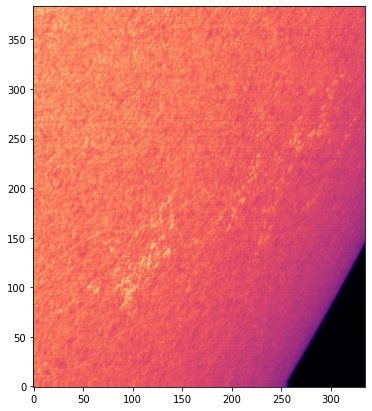

In [4]:
datacube = fits_file[0].data
picture = datacube[:,:,0,:]
print(picture.shape)
plt.figure(figsize=[10,7])
plt.imshow(picture[:,:,0],cmap='magma',origin='lower')
plt.savefig("picture.jpg",dpi=300)

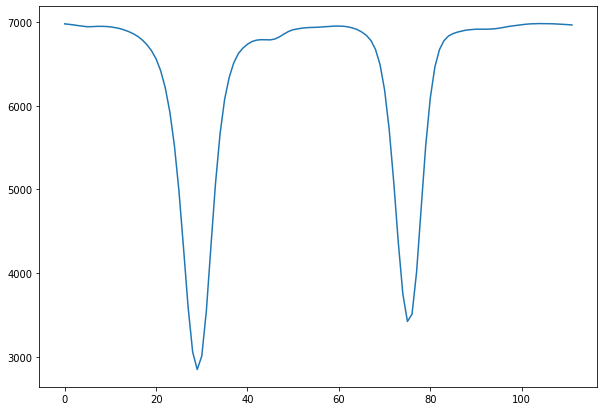

In [5]:
mean = np.mean(picture,axis=(0,1))
plt.figure(figsize=[10,7])
plt.plot(mean)

Text(0.5, 0, 'h [km]')

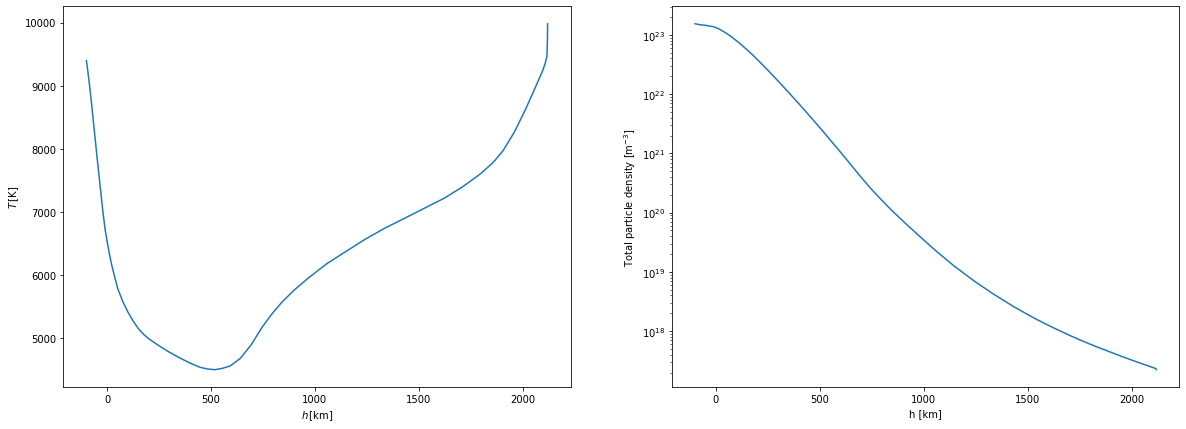

In [6]:
atmos = np.loadtxt("../falc.dat",unpack=True,skiprows=1) #load the atmos 
h = atmos[1]/ 1E2 # height in meters
T = atmos[2] # Temperature in Kelvin

N_total = atmos[3] / 1.38E-16 / T # transform total gass pressure to the total number of particles 
N_total *= 1E6 # transform to m^{-3} 

plt.subplots(nrows=1, ncols=2, figsize=(20, 7), sharex=True, sharey=True)
plt.subplot(121)
plt.plot(h/1E3,T)
plt.ylabel("$T\,\mathrm{[K]}$")
plt.xlabel("$h\, \mathrm{[km]}$")
plt.subplot(122)
plt.semilogy(h/1E3,N_total)
plt.ylabel("Total particle density $\mathrm{[m^{-3}]}$")
plt.xlabel("h [km]")

Text(0, 0.5, 'Population')

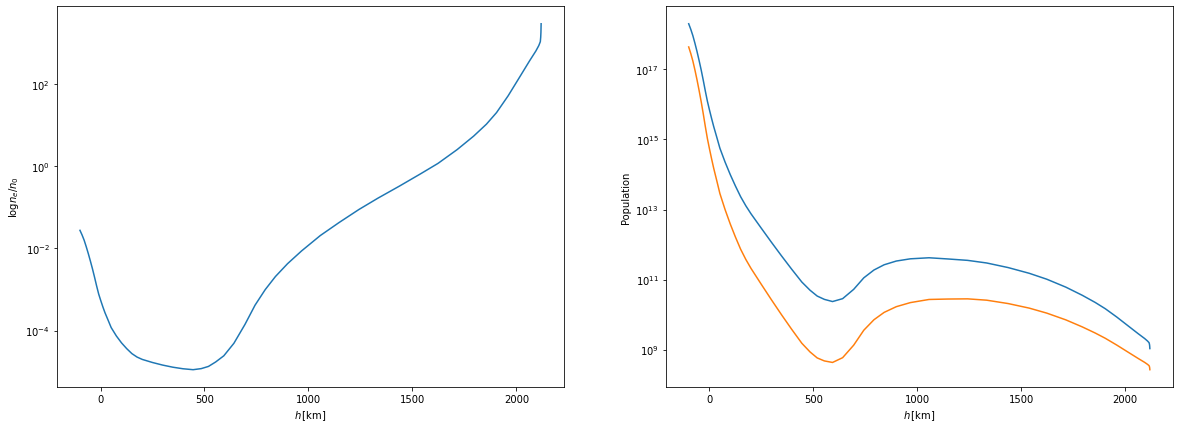

In [7]:
k = 1.38E-23 #Boltzmann constant 
me = 9.1E-31 # electron mass 
hp = 6.626E-34 #Planck function
c = 299792458. # speed of light

C_I = 0.5 * (2.0*np.pi*me*k/hp/hp)**-1.5 # constant term in saha equation

E_ion = 2.17896E-18 # ionization energy of hydrogen in Joules

#Saha, 'factor', S, coming from saha equation n_i+i * n_e / n_i = f(T)
f = 0.5 * np.exp(-E_ion/k/T) /C_I * T**1.5

# It can be shown that electron density is the positive solution of the quadratic equation
n_e = (-2.0 * f + (4*f*f + 4*f*N_total)**0.5 ) * 0.5
n_0 = n_e**2.0 / f

E_2 = 10.1988357  * 1.60218e-19 # second level energy in Joules
E_3 = 12.0875051  * 1.60218e-19 # third level
g_2 = 8.0 # statistical weight / degeneracy
g_3 = 18.0

n_2 = n_0 * np.exp(-E_2/k/T)*g_2 / 2.0 # 2 is the partition function of hydrogen
n_3 = n_0 * np.exp(-E_3/k/T)*g_3 / 2.0

plt.subplots(nrows=1,ncols=2,figsize=[20,7],sharex=True,sharey=True)
plt.subplot(121)
plt.semilogy(h/1E3,n_e/n_0)
plt.xlabel('$h\,\mathrm{[km]}$')
plt.ylabel('$\mathrm{log} n_e / n_0$')
plt.subplot(122)
plt.semilogy(h/1E3,n_2,label='Level 2')
plt.semilogy(h/1E3,n_3,label='Level 3')
plt.xlabel('$h\,\mathrm{[km]}$')
plt.ylabel('Population')

In [8]:
# So, to make wavelength, let's do something like this. 
NL = 112 #number of wavelengts
llambda = np.linspace(0,NL-1,NL)
llambda = 6302.08 + (llambda-56.5)*0.0215
llambda *= 1.00029 # We are used to working in air wavelengths, but we need to convert to vacuum now ;) 

ND = len(T) #number of depths

# line center wavelength
llambda0 = hp*c/(E_3 - E_2)

m_h = 1.67E-27 # mass of Hydrogen in kg, we need this for doppler width

A_32 = 4.4101e+07
B_32 = A_32 / (2.*hp*c*c/llambda0**5.0)
B_23 = B_32 * g_3 / g_2

print(A_32,B_32,B_23)

44101000.0 4.513880173031421e-08 1.0156230389320697e-07


In [9]:
# Let's define a Voigt function :-)

from scipy.special import wofz
def V(x, alpha, gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi)

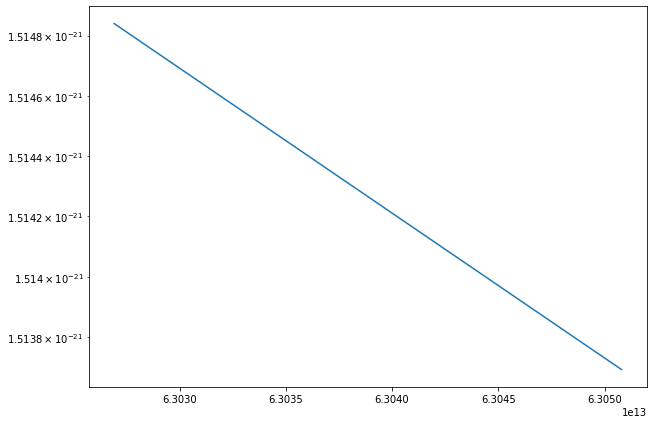

In [10]:
# Time to calculate opacity and emissivity! 
from astropy.modeling.models import Voigt1D

for d in range(0,ND): #for each depth
    
    # calculate doppler velocity
    dvd = np.sqrt(2*k*T[d]/m_h)
    
    # calculate doppler widht in wavelength units (m)
    dld = llambda0 / c * dvd
    
    # calculate Gaussian profile
    # Reduced wavelength
    x = (llambda-llambda0)/dld
    profile = V(x,1.0,1E-2)/dld
    #profile = 1./np.sqrt(np.pi)/dld * np.exp(-x*x)
    
    if (d==30):
        plt.figure(figsize=[10,7])
        plt.semilogy(llambda*1E10,profile)

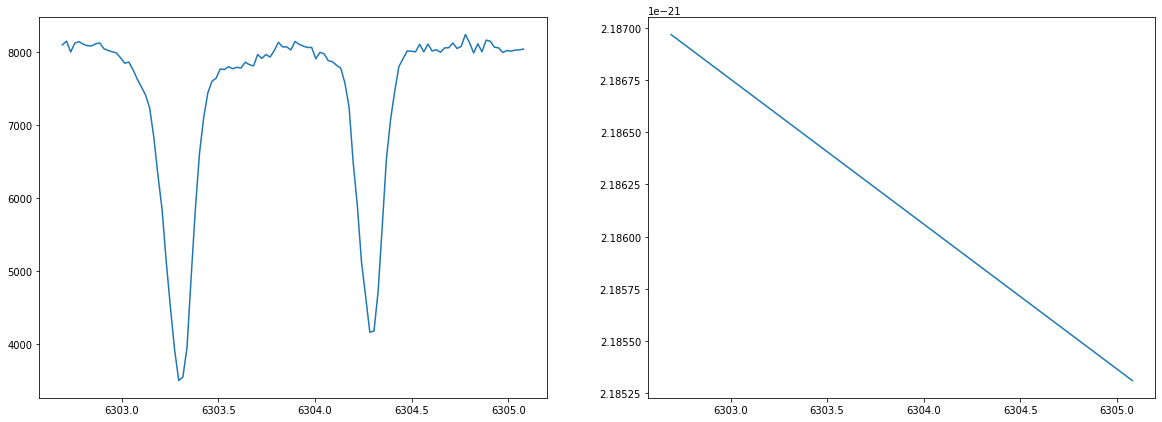

In [11]:
plt.subplots(nrows=1,ncols=2,figsize=[20,7],sharex=True,sharey=True)
plt.subplot(121)
plt.plot(llambda,picture[10,10,:])
plt.subplot(122)
plt.plot(llambda,profile)

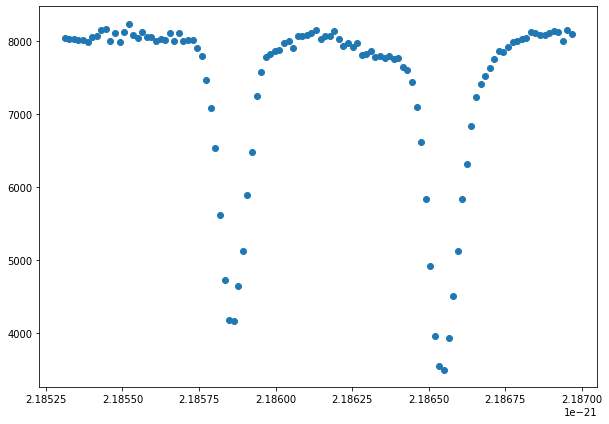

In [12]:
plt.figure(figsize=[10,7])
plt.plot(profile,datacube[10,10,0,:],'o')